### Reaction Diffusion equation in JAX

$\begin{aligned}
	&u_t = 0.01u_{xx}+0.01u^2, \quad t\in[0,1],x\in[-1,1], \\
	&u(x,0) = \sin(2\pi x)(1+\cos(2\pi x)).
\end{aligned}$

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import scipy
import matplotlib.pyplot as plt
import pickle
import copy
import time
from tqdm import trange
from typing import Sequence
from functools import partial

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
M = 5
L = 2.0
layer_sizes_u = [2*M+1] + [128] * 4 + [1] # output u_{n+1}
layer_sizes_k = [2*M+1] + [128] * 4 + [2] # output k1, k2

class Net(nn.Module):
    layer_sizes: Sequence[int]
    M: int
    L: float

    def setup(self):
        self.W1 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.W2 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.Wz = [nn.Dense(features=size, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()) for size in self.layer_sizes[1:]]
    
    def input_encoding(self, x):
        w = 2 * jnp.pi / L
        k = jnp.arange(1, M + 1)
        return jnp.hstack([jnp.ones(x.shape), jnp.cos(k*w*x), jnp.sin(k*w*x)])

    def __call__(self, x):
        X = self.input_encoding(x)
        U = nn.tanh(self.W1(X))
        V = nn.tanh(self.W2(X))

        H = nn.tanh(self.Wz[0](X))
        for linear in self.Wz[1:-1]:
            Z = nn.tanh(linear(H))
            H = jnp.multiply(1 - Z, U) + jnp.multiply(Z, V)
        return self.Wz[-1](H)

net_u = Net(layer_sizes_u, M, L)
net_k = Net(layer_sizes_k, M, L)

In [3]:
def mse_fn(true, pred):
    return jnp.mean(jnp.square(true - pred))

def diff(func, argnums):
    return jax.grad(lambda *ar, **kw: jnp.sum(func(*ar, **kw)), argnums=argnums)

@jax.jit
def train_step_u0(state, x_r, x_du0, u_true, du_true):
    def loss_fn(params):
        u_fn = lambda x: state.apply_fn(params, x)[:,-1:]
        du_x = diff(u_fn, 0)
        loss_f = 100*mse_fn(u_true, u_fn(x_r))
        loss_d = mse_fn(du_true, du_x(x_du0))
        
        loss = loss_f + loss_d
        return loss, (loss_f, loss_d)
    grads, (loss_f, loss_d) = jax.grad(loss_fn, argnums=0, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_f, loss_d

@jax.jit
def train_step_rest(state_u, state_k, x, uk, duk_x, duk_xx, N_t):
    h = 1/N_t
    p1 = h/4
    q1 = (1/4 + jnp.sqrt(3)/6)*h
    p2 = (1/4 - jnp.sqrt(3)/6)*h
    q2 = h/4

    def loss_u_fn(params_u, fk1, fk2):
        u_fn = lambda x: state_u.apply_fn(params_u, x)
        u = u_fn(x)

        loss_r = mse_fn((u-uk)/h, (fk1+fk2)/2)
        return loss_r, loss_r

    def loss_k_fn(params_k):
        k1_fn = lambda x: state_k.apply_fn(params_k, x)[:,0:1]
        dk1_x_fn = diff(k1_fn, 0)
        dk1_xx_fn = diff(dk1_x_fn, 0)
        k1 = k1_fn(x)
        dk1_x = dk1_x_fn(x)
        dk1_xx = dk1_xx_fn(x)

        k2_fn = lambda x: state_k.apply_fn(params_k, x)[:,1:2]
        dk2_x_fn = diff(k2_fn, 0)
        dk2_xx_fn = diff(dk2_x_fn, 0)
        k2 = k2_fn(x)
        dk2_x = dk2_x_fn(x)
        dk2_xx = dk2_xx_fn(x)

        fk1 = 0.01*(duk_xx+p1*dk1_xx+q1*dk2_xx) + 0.01*(uk+p1*k1+q1*k2)**2
        fk2 = 0.01*(duk_xx+p2*dk1_xx+q2*dk2_xx) + 0.01*(uk+p2*k1+q2*k2)**2
        loss_k1 = 1e2*mse_fn(fk1, k1)
        loss_k2 = 1e2*mse_fn(fk2, k2)
        loss_k = loss_k1 + loss_k2 
        return loss_k, (loss_k1, loss_k2, fk1, fk2)

    grads_k, (loss_k1, loss_k2, fk1, fk2) = jax.grad(loss_k_fn, argnums=0, has_aux=True)(state_k.params)
    grads_u, loss_r = jax.grad(loss_u_fn, argnums=0, has_aux=True)(state_u.params, fk1, fk2)
    
    state_k = state_k.apply_gradients(grads=grads_k)
    state_u = state_u.apply_gradients(grads=grads_u)
    return state_u, state_k, loss_k1, loss_k2, loss_r

In [4]:
# u(x, 0)
def U_x0(x):
    return jnp.sin(2*jnp.pi*x)*(1+jnp.cos(2*jnp.pi*x))

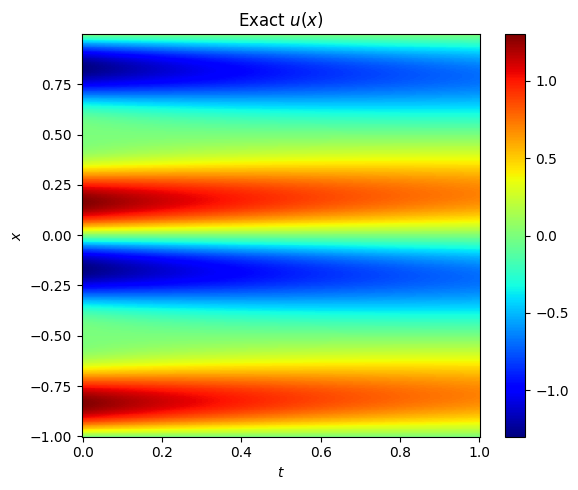

In [5]:
N_t = 200*1
N_x = 512
key = jax.random.PRNGKey(2023)
key, skey = jax.random.split(key)
dummy_x = jax.random.uniform(skey, (N_x, 1))
key, skey = jax.random.split(skey)
params_u = net_u.init(skey, dummy_x)
params_k = net_k.init(skey, dummy_x)

# Load the data and grid
data = np.load('data_RD_periodic.npz')
usol = data['usol']
t_star = np.linspace(0, 1, len(usol[0]))
x_star = data['X']
TT, XX = np.meshgrid(t_star, x_star)

# Plot the reference solution
fig = plt.figure(figsize=(6, 5))
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

X_r   = jnp.linspace(-1, 1, N_x).reshape(-1, 1)             # used to train u
X_du0 = jnp.linspace(-1, 1, N_x).reshape(-1, 1)[1:-1:1]     # used to train u_t
X_star= x_star.reshape(-1, 1)                               # used to predict
u0    = U_x0(X_r)                                           # reference solution of u(x, 0) when training
du0_x = diff(U_x0, 0)(X_du0)                                # reference solution of u_t(x, 0) when training
usol0 = usol[:,0].reshape(-1, 1)                            # reference solution of u when predicting

In [6]:
# Train u0
start_time = time.time()
print('Training u0')

#logger
loss_f_log = []
loss_d_log = []
l2_error_log = []
u_pred = []
l2_each_tn_log = []

# optimizer & schedule
lr_k = 1e-3
schedule = optax.exponential_decay(
    init_value=lr_k,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.adam(learning_rate=schedule)

# Train state
state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

# Load state
# pkl_file = pickle.load(open('Allen_Cahn/states/state{:d}.pkl'.format(0), 'rb'))
# state = flax.serialization.from_state_dict(state, pkl_file)

pbar = trange(1, 10000 + 1, ncols=150)
loss_min = 1e8
for nIter in pbar:
    state_u, loss_f, loss_d = train_step_u0(state_u, X_r, X_du0, u0, du0_x)
    loss = loss_f + loss_d
    
    # Save the best state
    if loss < loss_min:
        state_dict = flax.serialization.to_state_dict(state_u)
        pickle.dump(state_dict, open('states/state{:d}.pkl'.format(0), 'wb'))
        loss_min = loss
    
    if nIter % 1000 == 0:
        l2_error = jnp.linalg.norm(usol0 - state_u.apply_fn(state_u.params, X_star)) / jnp.linalg.norm(usol0)

        loss_f_log.append(loss_f)
        loss_d_log.append(loss_d)
        l2_error_log.append(l2_error)
        pbar.set_postfix_str('loss:{:.2e}, loss_f:{:.2e}, loss_d:{:.2e}, l2_error:{:.2e}, loss_min:{:.2e}'.format(loss, loss_f, loss_d, l2_error, loss_min))

# Load the best state
pkl_file = pickle.load(open('states/state{:d}.pkl'.format(0), 'rb'))
state_u = flax.serialization.from_state_dict(state_u, pkl_file)
u_pred.append(state_u.apply_fn(state_u.params, X_star))
l2_each_tn_log.append(jnp.linalg.norm(usol[:,0:1] - u_pred[-1]) / jnp.linalg.norm(usol[:,0:1]))
elapsed_u0 = time.time() - start_time

Training u0


100%|███████████████████| 10000/10000 [00:14<00:00, 709.66it/s, loss:1.87e-06, loss_f:9.33e-08, loss_d:1.78e-06, l2_error:4.15e-05, loss_min:1.82e-06]


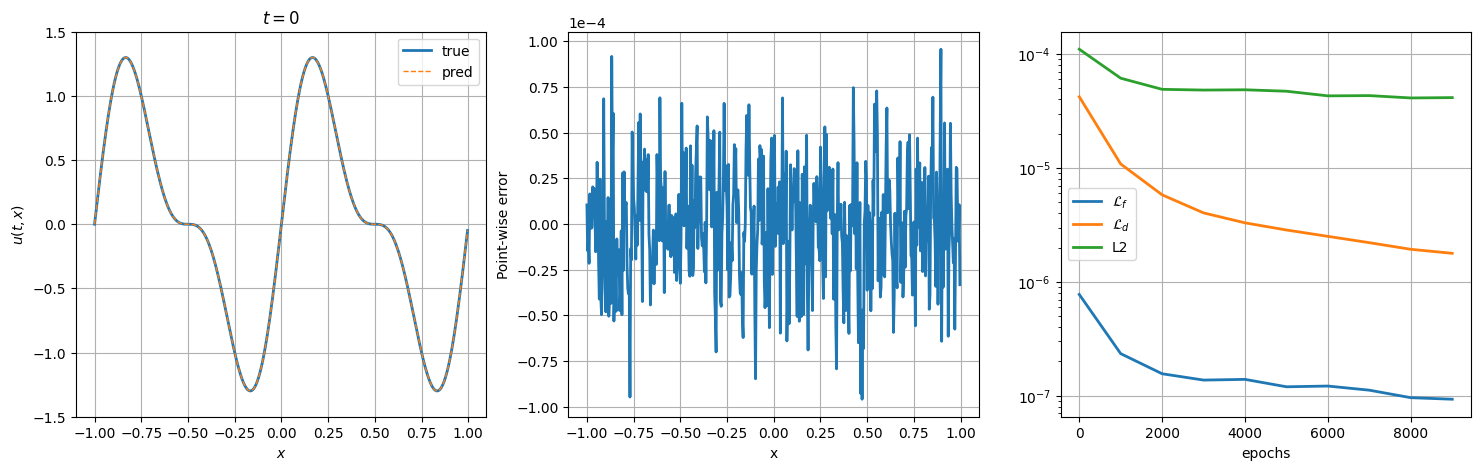

u0 training time: 14 s


In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.set_ylim(-1.5, 1.5)
ax1.plot(X_star, usol[:,0], label='true', linewidth=2)
ax1.plot(X_star, u_pred[0], label='pred', linewidth=1, linestyle='--')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(t, x)$')
ax1.set_title('$t = 0$')
ax1.legend()
ax1.grid(True)

ax2.ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
ax2.plot(X_star, usol0- u_pred[0], linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('Point-wise error')
ax2.grid(True)

plt.yscale('log')
ax3.plot(1000*np.arange(len(loss_f_log)), loss_f_log, label='$\mathcal{L}_{f}$', linewidth=2)
ax3.plot(1000*np.arange(len(loss_d_log)), loss_d_log, label='$\mathcal{L}_{d}$', linewidth=2)
ax3.plot(1000*np.arange(len(l2_error_log)), l2_error_log, label='L2', linewidth=2)
ax3.set_xlabel('epochs')
ax3.legend()
ax3.grid(True)
plt.show()

print('u0 training time: {:.0f} s'.format(elapsed_u0))

In [8]:
# Train u1 u2 u3 ...
start_time_rest = time.time()
print('Training u1 u2 u3 ...')

# logger
steps_each_tn_log = []
loss_min_log = []
loss_k1_log = []
loss_k2_log = []
loss_r_log = []

# optimizer & schedule
lr_u = 1e-5
schedule_u = optax.exponential_decay(init_value=lr_u,transition_steps=100,decay_rate=0.9)
optimizer_u = optax.adam(learning_rate=schedule_u)
lr_k = 1e-3
schedule_k = optax.exponential_decay(init_value=lr_k,transition_steps=100,decay_rate=0.95)
optimizer_k = optax.adam(learning_rate=schedule_k)

# Train state
# state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
# state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

pbar = trange(1, N_t + 1, ncols=150)
for t_n in pbar:
    loss_last = 0
    loss_min = 1e8
    loss_patience = 0
    
    # Use known Initial Condition when training u1
    if t_n == 1:
        duk_x_fn = diff(U_x0, 0)
        duk_xx_fn = diff(duk_x_fn, 0)
        uk = U_x0(X_r)
        duk_x = duk_x_fn(X_r)
        duk_xx = duk_xx_fn(X_r)
    else:
        uk_fn = lambda x: state_u.apply_fn(state_u.params, x)
        duk_x_fn = diff(uk_fn, 0)
        duk_xx_fn = diff(duk_x_fn, 0)
        uk = uk_fn(X_r)
        duk_x = duk_x_fn(X_r)
        duk_xx = duk_xx_fn(X_r)

    # Renew train state
    state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=state_u.params, tx=optimizer_u)
    state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=state_k.params, tx=optimizer_k)
    # state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
    # state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

    for steps in range(1, 10000 + 1):
        state_u, state_k, loss_k1, loss_k2, loss_r = train_step_rest(state_u, state_k, X_r, uk, duk_x, duk_xx, N_t)
        loss = loss_k1 + loss_k2 + loss_r
        pbar.set_postfix_str('steps:{:4d}, loss:{:.2e}, min:{:.2e}, k1:{:.2e}, k2:{:.2e}, r:{:.2e}, l2_last:{:.2e}'
                             .format(steps, loss, loss_min, loss_k1, loss_k2, loss_r, l2_each_tn_log[-1]))
        
        # Save the best state
        if loss < loss_min:
            state_dict = flax.serialization.to_state_dict(state_u)
            pickle.dump(state_dict, open('states/state{:d}.pkl'.format(t_n), 'wb'))
            loss_min = loss
            loss_patience = steps
        
        # Determine whether to proceed to the next time step
        if steps>1000 and (loss<1e-5 or 0<loss_last-loss<=1e-8 or steps-loss_patience>300):
            break
        loss_last = loss

    # Load the best state & predict
    pkl_file = pickle.load(open('states/state{:d}.pkl'.format(t_n), 'rb'))
    state_u = flax.serialization.from_state_dict(state_u, pkl_file)
    if t_n % (N_t/(len(usol[0])-1)) == 0:
        u_pred.append(state_u.apply_fn(state_u.params, X_star))
        t_index = int(t_n/N_t*(len(usol[0])-1))
        usol_tn = usol[:,t_index:t_index+1]
        l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))
    
    # Log
    steps_each_tn_log.append(steps)
    loss_min_log.append(loss_min)
    loss_k1_log.append(loss_k1)
    loss_k2_log.append(loss_k2)
    loss_r_log.append(loss_r)

elapsed_rest = time.time() - start_time_rest

Training u1 u2 u3 ...


100%|██████████████| 200/200 [12:13<00:00,  3.67s/it, steps:1001, loss:5.37e-05, min:4.71e-05, k1:6.43e-07, k2:6.20e-07, r:5.25e-05, l2_last:1.26e-04]


In [9]:
u_pred_copy = copy.deepcopy(u_pred)

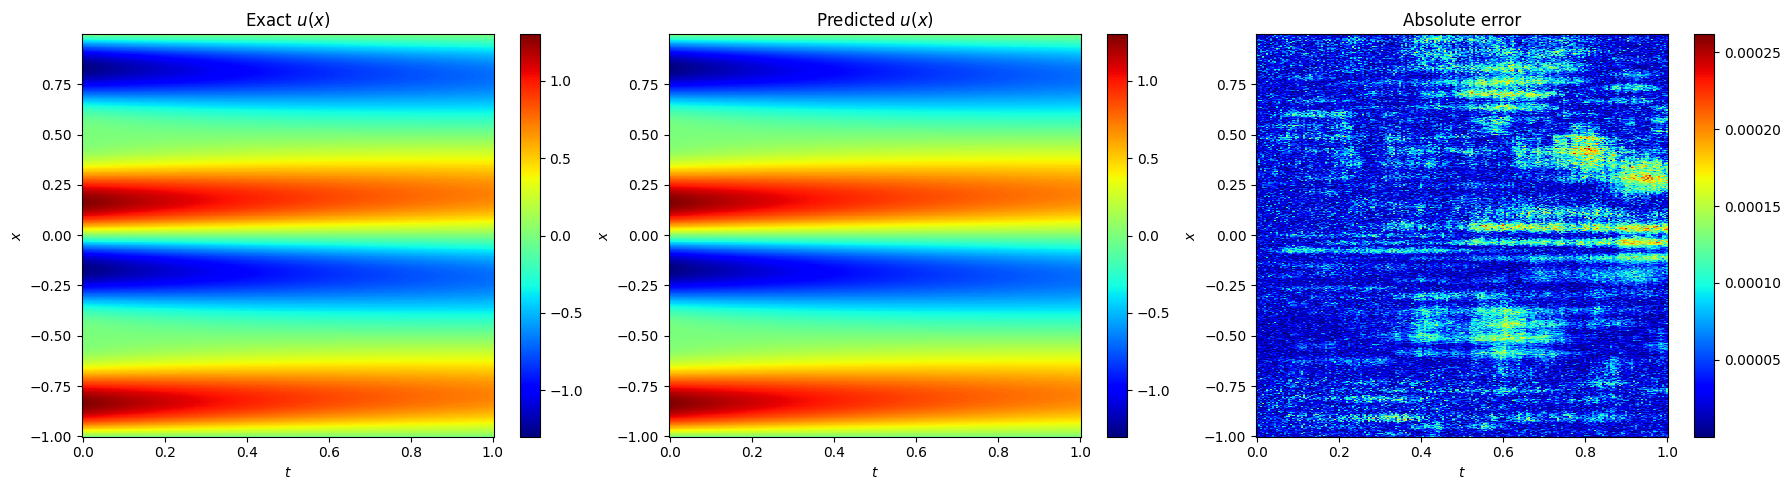

training time after u0: 734 s
total time: 748 s
L2 error = 9.33989e-05


In [10]:
# reshape to the same format & compute L2 error
u_pred = copy.deepcopy(u_pred_copy)
u_pred = np.reshape(u_pred, (len(usol[0]), len(usol))).T
l2_error = np.linalg.norm(usol - u_pred) / np.linalg.norm(usol)

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.show()

print('training time after u0: {:.0f} s'.format(elapsed_rest))
print('total time: {:.0f} s'.format(elapsed_u0+elapsed_rest))
print('L2 error = {:.5e}'.format(l2_error))

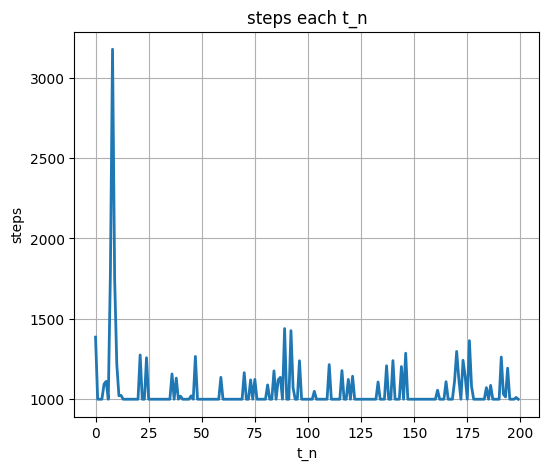

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(np.arange(len(steps_each_tn_log)), steps_each_tn_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('steps')
ax.set_title('steps each t_n')
ax.grid(True)
plt.show()

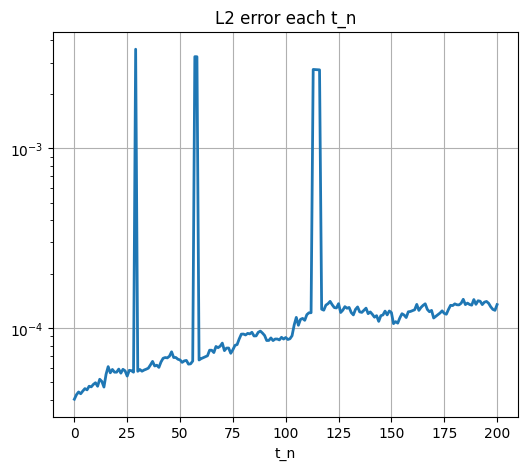

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(l2_each_tn_log)), l2_each_tn_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_title('L2 error each t_n')
ax.grid(True)
plt.show()

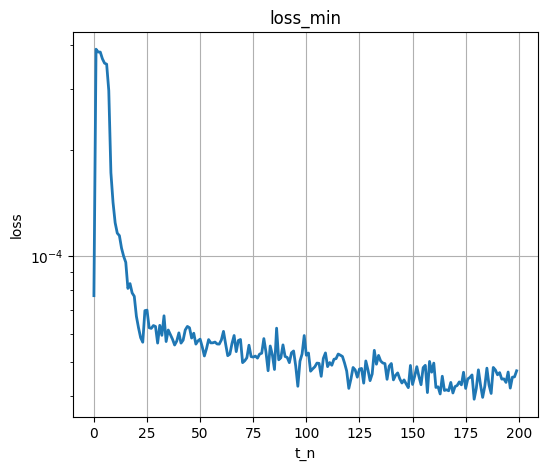

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(loss_min_log)), loss_min_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('loss')
ax.set_title('loss_min')
ax.grid(True)
plt.show()

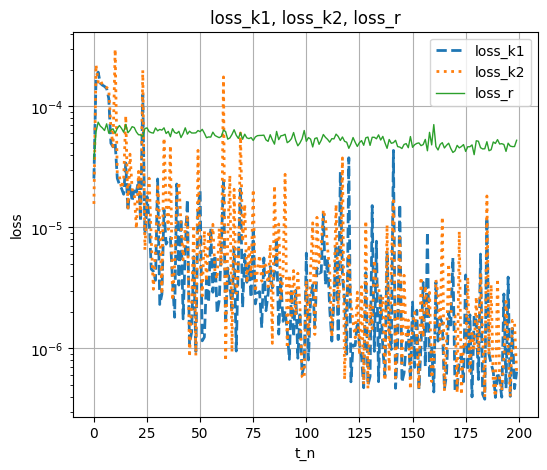

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(loss_k1_log)), loss_k1_log, label='loss_k1', linewidth=2, linestyle='--')
ax.plot(np.arange(len(loss_k2_log)), loss_k2_log, label='loss_k2', linewidth=2, linestyle=':')
ax.plot(np.arange(len(loss_r_log)), loss_r_log, label='loss_r', linewidth=1)
ax.set_xlabel('t_n')
ax.set_ylabel('loss')
ax.set_title('loss_k1, loss_k2, loss_r')
ax.legend()
ax.grid(True)
plt.show()